# Predicting the outcome of the 2017/2018 Premier League

The English Premier League (PL) is one of the most popular sporting leagues in the world. If we could predict the outcome of the league at the beginning of the year, then we would be able to make a considerable amount of money. At the time of writing, we are 10 games into the season and Manchester City look to be the clear favourites to lift the trophy. But I am not content with this layman's analysis. I want to know just how comfortably they should win the title, or whether some upstart team will wrest it from their grasp (Come on, Liverpool!). 

This is very much a work in progress and I am going to try to build on it as the season progresses, but I will publish it on my github as I go so that any eagle-eyed observers can spot my mistakes or give suggestions for improvements. I will guide the reader through my working as I go along, but this is not a substitute for a maths class. You will need to know basic maths to fully understand what's going on.

#### This version is being written after round 10 of the Premier League Season.

#### If you would like to contact me, please reach out on twitter (@jamesblood)



Before I do anything, I will need to import some libraries to work with the data, perform calculations, and visualise what we have. I'll start by loading numpy, pandas, matplotlib, and seaborn

In [2]:
#Working with the data
import pandas as pd
import numpy as np
#Visualising
import matplotlib.pyplot as plt
import seaborn as sns


### Loading data and some simple extractions

I have a csv file with the goals scored and conceded by each team both home and away, and their current points

In [3]:
df = pd.read_csv('17_18_PL_10_games.csv')
df.head()

,Team,Home For,Home Against,Away For,Away Against,Home Games,Away Games,Points
0,Manchester United,15,0,8,4,5,5,23
1,Manchester City,21,3,14,3,5,5,28
2,Arsenal,13,4,6,9,5,5,19
3,Liverpool,9,1,8,15,5,5,16
4,Brighton,6,5,4,6,5,5,12


Already we can see that the table isn't sorted by points and so to satisfy my OCD, we should fix that.

In [4]:
df = df.sort_values('Points',ascending=False)
df.head()

,Team,Home For,Home Against,Away For,Away Against,Home Games,Away Games,Points
1,Manchester City,21,3,14,3,5,5,28
0,Manchester United,15,0,8,4,5,5,23
5,Tottenham,7,4,12,3,5,5,20
7,Chelsea,8,6,10,4,5,5,19
2,Arsenal,13,4,6,9,5,5,19


How about looking at the description of this to see if anything obvious strikes us, or if any data is missing.

In [5]:
df.describe()

,Home For,Home Against,Away For,Away Against,Home Games,Away Games,Points
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,7.250000,5.700000,5.700000,7.250000,5.000000,5.000000,13.800000
std,4.447057,2.957595,3.628832,3.567027,0.324443,0.324443,5.872326
min,3.000000,0.000000,0.000000,3.000000,4.000000,4.000000,4.000000
25%,4.750000,4.000000,3.000000,4.000000,5.000000,5.000000,9.750000
50%,6.000000,6.000000,5.000000,7.000000,5.000000,5.000000,12.500000
75%,8.000000,7.500000,8.000000,9.250000,5.000000,5.000000,16.750000
max,21.000000,11.000000,14.000000,15.000000,6.000000,6.000000,28.000000


None of the data is missing, which is a relief because I made this myself. We need to know the league average goals scored and conceded per game for both home and away teams, so we can sum the respective columns and divide by the number of games to get these.

In [35]:
home_for = df['Home For'].sum() / df['Home Games'].sum()
home_against = df['Home Against'].sum() / df['Home Games'].sum()
away_for = df['Away For'].sum() / df['Away Games'].sum()
away_against = df['Away Against'].sum() / df['Away Games'].sum()

print(
    ' Home for average: ',
    home_for,
    '\n',
    'Home against average: ',
    home_against,
    '\n',
    'Away for average: ',
    away_for,
    '\n',
    'Away against average: ',
    away_against,
    '\n' )

 Home for average:  1.45 
 Home against average:  1.14 
 Away for average:  1.14 
 Away against average:  1.45 



We divided this by 5 because that is the average number of matches for both home and away. And happily the average number of home goals score is the same as the number of away goals conceded, and vice versa.

Already we have enough information to run a rudimentary model for your standard home team against the standard away team, so let's try that.

The Poisson probability distribution is a decent approximation here, if we assume that scoring a goal is an independent event, and that goals are scored at a constant rate throughout the match. In actual fact these assumptions are not quite true, but they will do for now. With these assumptions in place, we can work out the probability of k events happening by 

$$ P(k) = e^{\lambda}\frac{\lambda^k}{k!} $$

Where $\lambda$ is the rate parameter, and k is a the number of events in the interval and is an integer (0,1,2,...)

Now we could try and code this ourselves, but for a few reasons, we won't. Some clever bods have designed a stats library for python, so we can import scipy.stats.poisson and start to examine what we have.

In [8]:
from scipy.stats import poisson

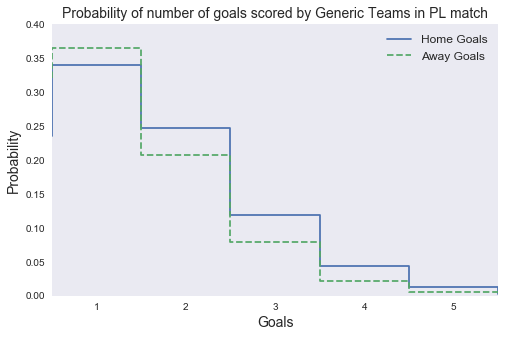

In [24]:
rates = [home_for,away_for]
line_styles = ['-','--']
labels = ['Home Goals','Away Goals']
k = np.arange(0,200)

fig, ax = plt.subplots(figsize=(8,5))

for rate,line,lab in zip(rates,line_styles,labels):
    dist = poisson(rate)
    plt.plot(k,dist.pmf(k),label = lab,linestyle=line,drawstyle='steps')
plt.xlabel('Goals',size=14)
plt.ylabel('Probability',size=14)
plt.title('Probability of number of goals scored by Generic Teams in PL match',size=14)

goals = np.arange(1,6)
ax.xaxis.set(ticks = np.arange(0.5,len(goals)),ticklabels = goals)
ax.grid(False)

plt.xlim(0,5)
plt.ylim(0,0.4)
plt.legend(fontsize = 12)
plt.show()

As you can see, the two generic teams look to be evenly matched with the home team having a slight advantage. The probability of a generic team scoring more than 5 goals appears to be rather small, so we can terminate our calculations at k = 5. 

We can multiply the probabilities of each team scoring x number of goals and their opponents scoring y goals with a matrix multiplication and then plot a heatmap to see what is the most likely score.

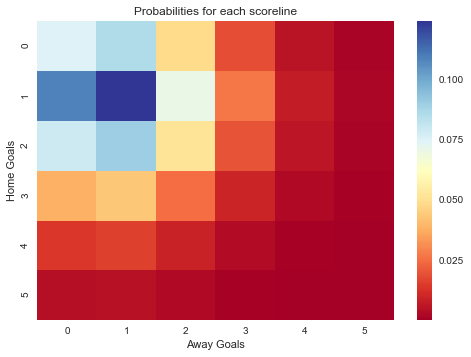

In [45]:
#Get numpy arrays with probabilities for goals up to 5
hg = np.array([poisson(home_for).pmf(k) for k in np.arange(6)])
ag = np.array([poisson(away_for).pmf(k) for k in np.arange(6)])

#Multiply matrices to get probabilities of scores
scores = np.outer(hg,ag)

#Plot the heatmap
sns.heatmap(scores,cmap='RdYlBu')
plt.ylabel('Home Goals')
plt.xlabel('Away Goals')
plt.title('Probabilities for each scoreline')
plt.show()


Our heatmap shows that the most likely score is a 1-1 draw, with this result occuring a little over 10% of the time. This should hardly be surprising if we look back to the average number of goals scored, 1.45 and 1.14 for home and away respectively. However, as football fans, we know that this is not right: 1-1 is not the most common scoreline in the PL. Of course this is because some teams are stronger than others, and that is what we will start to look at in the next update.